In [1]:
from __init__ import *

def load_csv_and_tag(file_path, tag):
    df = pd.read_csv(file_path)
    df['wm_ch'] = tag
    return df

In [ ]:
# temp, next run we should have already saved them into one fiel from the mergeing step

df_4ch = load_csv_and_tag('/is/sg2/mkaut/ma-thesis/experiments/exp2/_results/num_100_fpr_0.01_cfg_3.0_wmch_4_merged.csv', 4)
df_8ch = load_csv_and_tag('/is/sg2/mkaut/ma-thesis/experiments/exp2/_results/num_100_fpr_0.01_cfg_3.0_wmch_8_merged.csv', 8)
df_12ch = load_csv_and_tag('/is/sg2/mkaut/ma-thesis/experiments/exp2/_results/num_100_fpr_0.01_cfg_3.0_wmch_12_merged.csv', 12)
df_16ch = load_csv_and_tag('/is/sg2/mkaut/ma-thesis/experiments/exp2/_results/num_100_fpr_0.01_cfg_3.0_wmch_16_merged.csv', 16)

In [ ]:
# merge all 4 dataframes, should be no duplicates (but better check)
df = pd.concat([df_4ch, df_8ch, df_12ch, df_16ch], ignore_index=True)

# save the merged dataframe
df.to_csv('/is/sg2/mkaut/ma-thesis/experiments/exp2/_results/coco/num_100_fpr_0.01_cfg_3.0_wmch_16/exp2_merged.csv', index=False)
df

In [ ]:
# the df has 5 wm_method, 2 model_id, (1 dataset_id, ignore for now) 2 attack_type, 3 attack_names, 
# and depending on the attack_type 1 or 5 attack strengths ('no_attack' has only one strenght, every other attack_type has 5), and tpr_empirical

# we want to calculte a new table/df in which we have taken the mean over the attack_strengths
# only per wm_ch type (can be 4, 8, 12, 16) for each model id seperately:

model_ids = df['model_id'].unique()
wm_methods = df['wm_method'].unique()
attack_types = df['attack_type'].unique()
attack_names = df['attack_name'].unique()
wm_chs = df['wm_ch'].unique()
attack_strengths = df['attack_strength'].unique()

print(f"model_ids: {model_ids}")
print(f"wm_methods: {wm_methods}")
print(f"attack_types: {attack_types}")
print(f"attack_names: {attack_names}")
print(f"wm_chs: {wm_chs}")
print(f"attack_strengths: {attack_strengths}")

# Calculate Mean over attack strengths (TABLE)

In [ ]:
# loop over model_ids
for model_id in model_ids:
    model_df = df[df['model_id'] == model_id]
    # check if empty
    if model_df.empty:
        print(f"Model ID {model_id} has no data.")
        continue
    else:
        print(f"\nModel: {model_id}")
    
    # loop over wm_methods
    for wm_method in wm_methods:
        wm_df = model_df[model_df['wm_method'] == wm_method]
        # check if empty
        if wm_df.empty:
            print(f"\tWM method {wm_method} has no data for model ID {model_id}.")
            continue
        else:
            print(f"\tWM method: {wm_method}")
        for attack_name in attack_names:
            attack_df = wm_df[model_df['attack_name'] == attack_name]
            # check if empty
            if attack_df.empty:
                print(f"\t\tAttack name {attack_name} has no data for model ID {model_id} and WM method {wm_method}.")
                continue
            else:
                print(f"\t\tAttack name: {attack_name}")
            for wm_ch in wm_chs:
                wm_ch_df = attack_df[attack_df['wm_ch'] == wm_ch]
                # check if empty
                if wm_ch_df.empty:
                    print(f"\n\t\t\tWM channel {wm_ch} has no data for attack name {attack_name}, model ID {model_id}, and WM method {wm_method}.")
                    continue
                else:
                    print(f"\n\t\t\tWM channel: {wm_ch}")
                
                attack_strengths = wm_ch_df['attack_strength'].unique()
                #print(f"\t\t\t\tattack strengths: {attack_strengths}")
                #print(f"\t\t\t\ttpr empirical values: {wm_ch_df['tpr_empirical'].values}")
                #print(wm_ch_df)
                mean_tpr = wm_ch_df['tpr_empirical'].mean()
                std_tpr = wm_ch_df['tpr_empirical'].std()
                print(f"\t\t\t\tMean TPR: {mean_tpr:.3f}+-{std_tpr:.3f}")
            

# Plot Comparisons

compare_variable: wm_ch
compare_variables: [ 4  8 12 16]
manually clippinf ci_lower and ci_upper for crop_scale, grids, 4
manually clippinf ci_lower and ci_upper for crop_scale, grids, 8
manually clippinf ci_lower and ci_upper for crop_scale, grids, 12
manually clippinf ci_lower and ci_upper for crop_scale, grids, 16
manually clippinf ci_lower and ci_upper for jpeg_ratio, grids, 4
manually clippinf ci_lower and ci_upper for jpeg_ratio, grids, 8
manually clippinf ci_lower and ci_upper for jpeg_ratio, grids, 12
manually clippinf ci_lower and ci_upper for jpeg_ratio, grids, 16
manually clippinf ci_lower and ci_upper for no_attack, grids, 4
manually clippinf ci_lower and ci_upper for no_attack, grids, 8
manually clippinf ci_lower and ci_upper for no_attack, grids, 12
manually clippinf ci_lower and ci_upper for no_attack, grids, 16


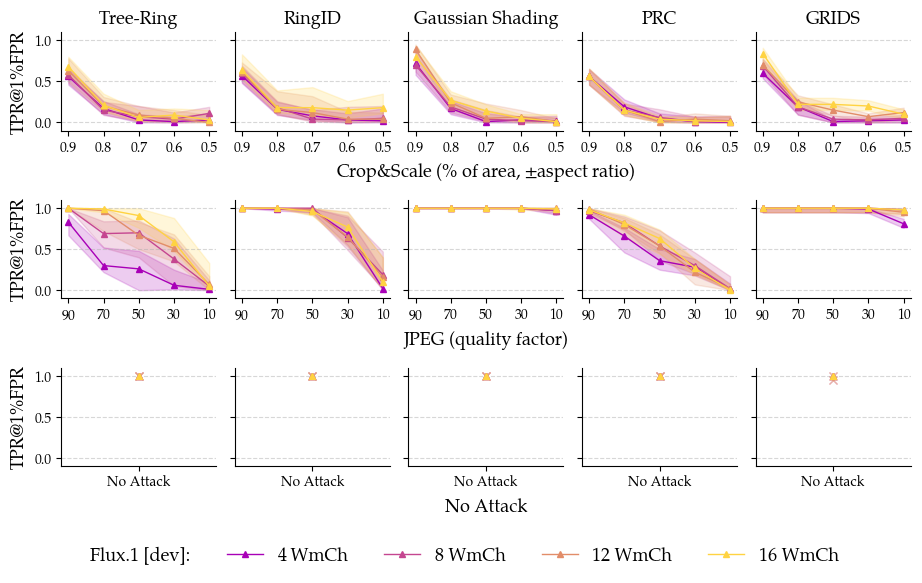

Plot saved to experiments/exp2/_results/coco/num_100_fpr_0.01_cfg_3.0_wmch_16/exp2_plot_flux.pdf
compare_variable: wm_ch
compare_variables: [ 4  8 12 16]


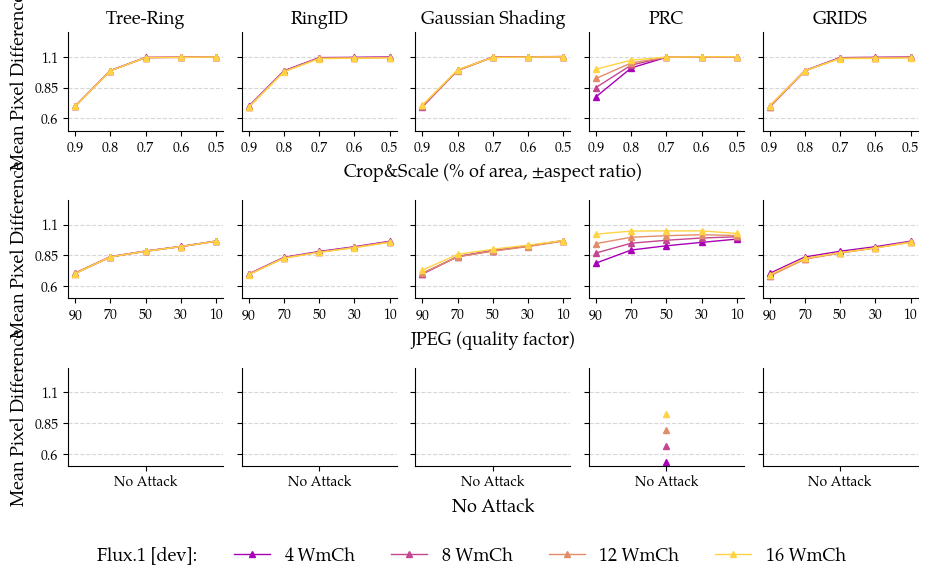

Plot saved to experiments/exp2/_results/coco/num_100_fpr_0.01_cfg_3.0_wmch_16/exp2_plot_flux_wm_diff.pdf
compare_variable: wm_ch
compare_variables: [ 4  8 12 16]
manually clippinf ci_lower and ci_upper for crop_scale, grids, 4
manually clippinf ci_lower and ci_upper for crop_scale, grids, 8
manually clippinf ci_lower and ci_upper for crop_scale, grids, 12
manually clippinf ci_lower and ci_upper for crop_scale, grids, 16
manually clippinf ci_lower and ci_upper for jpeg_ratio, grids, 4
manually clippinf ci_lower and ci_upper for jpeg_ratio, grids, 8
manually clippinf ci_lower and ci_upper for jpeg_ratio, grids, 12
manually clippinf ci_lower and ci_upper for jpeg_ratio, grids, 16
manually clippinf ci_lower and ci_upper for no_attack, grids, 4
manually clippinf ci_lower and ci_upper for no_attack, grids, 8
manually clippinf ci_lower and ci_upper for no_attack, grids, 12
manually clippinf ci_lower and ci_upper for no_attack, grids, 16


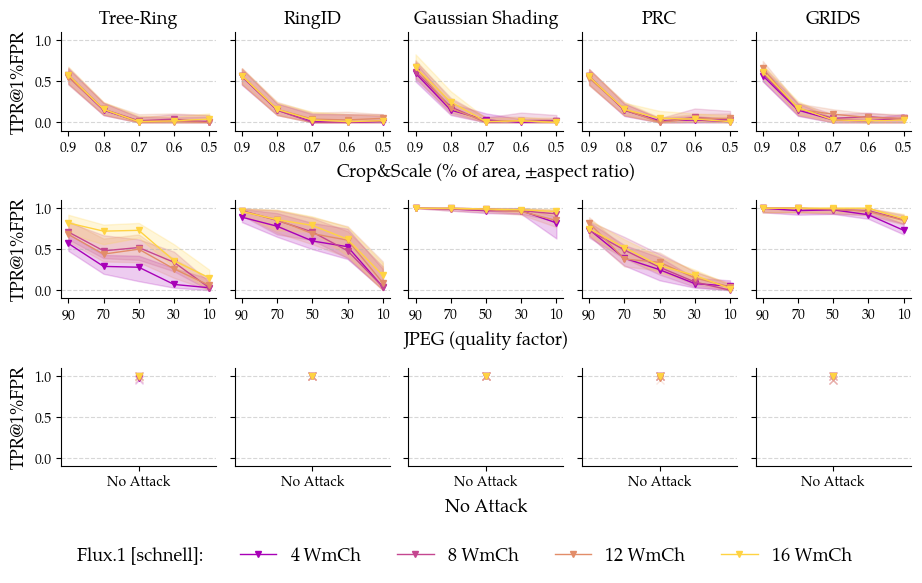

Plot saved to experiments/exp2/_results/coco/num_100_fpr_0.01_cfg_3.0_wmch_16/exp2_plot_flux_s.pdf
compare_variable: wm_ch
compare_variables: [ 4  8 12 16]


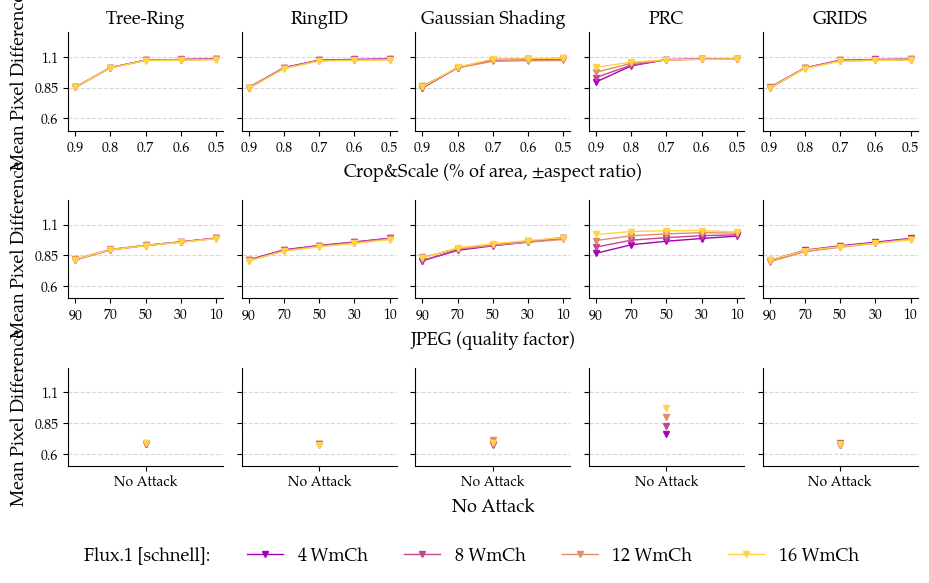

Plot saved to experiments/exp2/_results/coco/num_100_fpr_0.01_cfg_3.0_wmch_16/exp2_plot_flux_s_wm_diff.pdf


In [2]:
args = Namespace()
args.exp_name = 'exp2'


# specify which experimental setup we want to plot
args.num_imgs = 100
args.prompt_dataset = 'coco'

# for exp1, we merge results over wmch_16 for Flux and wmch_4 for SD
args.dataset_identifier = [f'num_{args.num_imgs}_fpr_0.01_cfg_3.0_wmch_16', 
                           f'num_{args.num_imgs}_fpr_0.01_cfg_3.0_wmch_12',
                           f'num_{args.num_imgs}_fpr_0.01_cfg_3.0_wmch_8',
                           f'num_{args.num_imgs}_fpr_0.01_cfg_3.0_wmch_4'] 

# create the output directories and ffilenames
args.input_dir = os.path.join('experiments', args.exp_name)
args.output_dir = os.path.join('experiments', args.exp_name, '_results', args.prompt_dataset,  args.dataset_identifier[0])
if not os.path.exists(args.output_dir):
    os.makedirs(args.output_dir)
args.merged_result_csv = os.path.join(args.output_dir, 'exp2_merged.csv')

# merged results already created in 5_merge_results.py
results_df = pd.read_csv(args.merged_result_csv)

# plot the results for only the flux model
df_flux = results_df[results_df['model_id'] == 'flux']
# args.title = (
#     f'Exp2: Effect of Watermark Channel on Perfomance\n' \
#     f'for dataset "{args.prompt_dataset}" and model "Flux-[dev]"\n' \
# )
args.output_plot = os.path.join(args.output_dir,  'exp2_plot_flux.pdf')
plot_tpr_per_attack_compare_variable(args, df_flux, 'tpr_empirical', 'wm_ch', WMCH_NAME_MAPPING)

args.output_plot = os.path.join(args.output_dir,  'exp2_plot_flux_wm_diff.pdf')
plot_tpr_per_attack_compare_variable(args, df_flux, 'wm_diff', 'wm_ch', WMCH_NAME_MAPPING,)

df_flux_s = results_df[results_df['model_id'] == 'flux_s']
# args.title = (
#     f'Exp2: Effect of Watermark Channel on Perfomance\n' \
#     f'for dataset "{args.prompt_dataset}" and model "Flux-[schnell]"\n' \
# )
args.output_plot = os.path.join(args.output_dir,  'exp2_plot_flux_s.pdf')
plot_tpr_per_attack_compare_variable(args, df_flux_s, 'tpr_empirical', 'wm_ch', WMCH_NAME_MAPPING)

args.output_plot = os.path.join(args.output_dir,  'exp2_plot_flux_s_wm_diff.pdf')
plot_tpr_per_attack_compare_variable(args, df_flux_s, 'wm_diff', 'wm_ch', WMCH_NAME_MAPPING)
